# Whiteboarder

<img src="https://johntigue.github.io/whiteboarder/images/three_expos.png" />

Whiteboarder is an interactive tool for processing whiteboard images: image clean-up, background removal, etc. A post-production studio just for whiteboard capture images.

In particular, the whiteboard images to be processed will only have 3 colored pens: black, red, and green on a white background.

## Motivation

Main goal is obviously to have a task specific image processing studio for whiteboard capture pictures. A sub-goal is to explore how far Colab's little UI extensions can be pushed to make an end-user tool out of a notebook, with the code hidden but available for those brave souls who don't mind staring into the angry fruit salad.

## Dev POR and status

While surveying the prior art, found that there are lots of statistical image processing techniques for, say, white balancing but not whiteboards specifically. There are even learning-based solutions that get trained on a large dataset. But for specific whiteboard capture and clean-up, not much was found except Fred on ImageMagick.


So, let's test drive some of the prior art and then get into some hand crafting of modern ML tools. Then it's time for pure Python image manipulation. Python has a lot of very nice and easy to use libraries.


 Tensoflow models on TFX Pipelines, etc. See if Google image search can get a ton of images to train on. Then use non-learning image segmentation techniques to generate training masks for a CNN which will be trained to remove whiteboard background white-ish field.

More potential ML e.g.s: 
- Whiteboard frame detector and image aligner
- Smarter clean-up:VAE, autoencoders
- OCR
- Flowchart recognizer would be next level


## History
2020-04-28: 
- Finish 3-4 days of image formatting, color<==>grayscale, histograms

2020-04-22:
- Start with OpenCV experiments

2020-04-21:
- Started notebook
- Got some Fred on ImageMagick working but not great at all
  - Halogen yellow is background and fucks with red ink


# Colab config


Colab comes with many preloaded software packages. This section performs any required initialization of the system:
- VM installations 
- Python imports
- File system set up
- Google Drive mount

## Installations

In [1]:
!apt -qq install -y imagemagick # mouthy install!
!apt -q install bc # Fred's whiteboard wants this

!apt -q install tree

The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts imagemagick
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsi

## Imports



This is the place to start for re-runs after `Runtime` => `Restart Runtime`. Rather than `Run all` choose `Run after` to bypass slow installs above here.

In [0]:
import cv2
import google.colab
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import skimage.color 
import skimage.exposure
import skimage.io

from IPython.display import display

import bokeh.io
from bokeh.models import ColumnDataSource, Step
from bokeh.models import LinearAxis, Range1d
import bokeh.plotting

from google.colab.data_table import DataTable

#import seaborn as sns
#sns.set() # style="whitegrid")

In [0]:
# This needs to be called once per notebook, otherwise Bokeh plots fail silently.
bokeh.io.output_notebook()

## File system workspace



A simple organized workspace on the file system makes for cleaner, more efficient code: e.g. enable a download caching mechanis, useful during frequent restarts as can happen (by design) on Colab.

This notebook will only (intentionally) create files in directory, `/content/whiteboarder/`.

- `/`: file system root
  - `content/`: default home/pwd on Colab 
    - `whiteboarder/`: this notebooks workspace
      - `cache/`: an organized downloads
      - `built/`: output of the notebook
        - various images

In [0]:
workspace_root_path = '/content/whiteboarder/' # /content is Colab's default dir
cache_path = workspace_root_path + 'cache/'

# Add/remove dirs
!rm -r sample_data/ # Don't need it. Noise.
!mkdir {workspace_root_path} # Put everything in here
!mkdir {cache_path} # downloaded files

## Utilities



### `reconstrue.colab` Class

In [0]:
def reconstrue_dot_humanize_bytes(num, suffix='B'):
  """ Via # https://stackoverflow.com/a/1094933"""

  for unit in ['','K','M','G','T','P','E','Z']:
    if abs(num) < 1024.0:
      return "%3.1f%s%s" % (num, unit, suffix)
    num /= 1024.0
  return "%.1f %s%s" % (num, 'Yi', suffix)

# TODO: module will be reconstrue.textual.humanize_bytes. This fakes the import
humanize_bytes = reconstrue_dot_humanize_bytes

### Image viewer

A Colab image viewer. A resizable image viewer (based on Plotly) with zoom and pan that works well in fullscreen mode on Colab:

In [0]:
import plotly.graph_objects as go

class Reconstrue:

  # TODO: assumes PIL.Image
  def display_pil_image(image_to_show, scale_factor): 
    # TODO: want to set viewport dimensions to output cell, not image_to_show 
  
    # Create figure
    fig = go.Figure()
      
    # Constants
    h, w = image_to_show.size
    img_width = h
    img_height = w
  
    #scale_factor = 0.15 
    # TODO: want scale_factor sensitive to cell/window width, else controls off screen to right.
    # There is also Colab API for checking and requesting output size. What about when in full screen; there is resize logic already
  
    # Add invisible scatter trace.
    # This trace is added to help the autoresize logic work.
    fig.add_trace(
      go.Scatter(
      x=[0, img_width * scale_factor],
      y=[0, img_height * scale_factor],
      mode="markers",
      marker_opacity=0
     )
    )
      
    # Configure axes
    fig.update_xaxes(
      visible=True,
      showgrid=False,
      range=[0, img_width] #range=[0, img_width * scale_factor]
    )
      
    fig.update_yaxes(
      visible=True,
      showgrid=False,
      range=[0, img_height],#range=[0, img_height * scale_factor],
      # the scaleanchor attribute ensures that the aspect ratio stays constant
      scaleanchor="x"
    )
      
    # Add image
    fig.update_layout(
      images=[go.layout.Image(
        x=0,
        sizex=img_width, # * scale_factor,
        y=img_height, # * scale_factor,
        sizey=img_height, # * scale_factor,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=image_to_show)] #input_image)] # "https://raw.githubusercontent.com/michaelbabyn/plot_data/master/bridge.jpg")]
    )
      
    # Configure other layout
    fig.update_layout(
      width=img_width * scale_factor,
      height=img_height * scale_factor,
      margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
      
    fig.show()

#Reconstrue.display_image(None, None)

# Input mode

The main goal here is to have a whiteboard capture post-production "studio." True utility is to be found by folks getting their own whiteboard capture images into Colab's Jupyter kernel and VM file system. Multiple methods are possible. The default is to read from a demo URL so that things work out of the box if someone reading wants to test the code with a `Runtime => Run All`.

In [0]:
#@title Choose input mode
input_mode = "Read from an URL" #@param ["Read from an URL", "Take a Picture", "Upload a File", "Mount Google Drive"]

# The main goal of the rest of this section is to set in_file_name
in_file_name = 'UNINITIALIZED'

## Read from an URL

The default mode is to just download an image from an URL. This mode is default simply because readers can "Runtime => Run All" and things will work out of the box, as opposed to needing to sign in to Google Drive or upload a file.

**TODO:** only handles .jpg files.


In [8]:
# This purple_noise*.jpg image has a bit of purple in it:
purple_noise_url = 'https://johntigue.github.io/whiteboarder/images/demo_captured_boards/purple_noise.jpg'

if input_mode == 'Read from an URL':
  print('Input mode is "Read from an URL"')

  an_example_url = purple_noise_url
  downloaded_file_name = cache_path + 'downloaded.jpg'

  response = requests.get(an_example_url)
  with open(downloaded_file_name, 'wb') as f:
    f.write(response.content)

  in_file_name = downloaded_file_name


Input mode is "Read from an URL"


In [9]:
!ls {cache_path}

downloaded.jpg


## Take a picture in-browser

Colab docs have [Camera Capture](https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi): 
> Using a webcam to capture images for processing on the runtime.

```python
# Paraphrasing
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      ...
      const video = document.createElement('video');
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      await video.play();

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);
      const canvas = document.createElement('canvas');
      ...
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename
```

## Upload a file



If you do not want to mount Google Drive on to Colab's file system, the alternative is to upload a file from your localhost. Just set `in_file_name` to the name of the file.

```python
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('File uploaded with name "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
```

## Mount Google Drive


It is very easy to mount one's Google Drive to a Colab VM's file system. (Colab VMs have a max life of 12 hours before they are killed off. Every time the runtime is reset, the Google Drive signin rigmarole is required, 6 clicks and a few keystroke.

Additional there are tons of way to integrate client devices with Google Drive. So, for the above two reasons gDrive makes for a fine repository and relay point for images.

Python code downloading from gDrive make for notebooks that re-run well enough, meh. It's better than repeatedly manually uploading files; that's much more of a hassle than having to re-login once in a while. Of course, read from an URL is easiest to rerun.

In [0]:
# Mount google drive
gdrive_dir_name = workspace_root_path + 'gdrive'

if input_mode == "Mount Google Drive":
  print('Input mode is "Mount Google Drive" so please enter password cookie to auth mounting.')
  # This next is a hassle. It requires manual web UI auth routine.
  google.colab.drive.mount(gdrive_dir_name)
  in_file_name = copy_a_file_from_gdrive('/content/whiteboarder/cache/some_file.jpg') #TODO 


In [0]:
if input_mode == "Mount Google Drive":
  !ls -lh {gdrive_dir_name}
  gdrive_data_root_path = gdrive_dir_name + '/My Drive/Professional/Reconstrue/Whiteboard/2020/2020-04/'

  # Annoyingly there's a space in the dir name `/My Drive/` so quoting is in order.
  !tree -L 5 "{gdrive_data_root_path}"

# Grayscale

Compared to dealing with color images, processing grayscale makes for clearer UI as well as simpler code. Let's see what can be achieved simply by filtering on grayscale intensities, no color info at first.

Whiteboard images are normally captured as color images (on a cellphone capturing 3 colored pens on a white board). Nonetheless, grayscale is useful for simply generating a foreground/background binary mask. That mask could then be used to set everything else to background (white or transparent). What would be left would be the original color-ful part of the image. 

So, one line of attack might be:
- User picks a single cut-off threshold intensity
- Anything below cut-off threshold is foreground
- Turn foreground into a binary mask 
- Merge images
  - Create a blank background image 
  - Add the original color image, limited to mask's ON pixels


## Image stats

The skimage package is NumPy based. The skimage docs even have a short valuable read, [A crash course on NumPy for images](https://scikit-image.org/docs/dev/user_guide/numpy_images.html). Many microscopy and related image processing techniques use herein are also NumPy bases. So, NumPy it is.

Having adopted skimage, might as well use skimage file I/O.

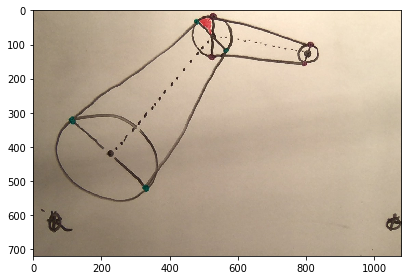

In [12]:
in_image = skimage.io.imread(in_file_name)
_ = skimage.io.imshow(in_image)

How big are the pics? (MacBook Pro camera seems to be 1080x720 which is close to 100K in size). Note, in skimage coordinates (0, 0) is upper left.

In [13]:

print(f'(height, width, channels) = {in_image.shape}\n')
print(f'file size = {humanize_bytes(os.stat(in_file_name).st_size)}\n')

# Print upper left pixel
print(in_image[0,0])


(height, width, channels) = (720, 1080, 3)

file size = 98.0KB

[158 142 119]


So, skimage reads JPEGs as (R_uint8, G_uint8, B_uint8). 

## Color to grayscale

If translating a color image to grayscale, algorithms usually use [relative luminance](https://en.wikipedia.org/wiki/Relative_luminance) formulas (via [stackoverflow](https://stackoverflow.com/a/54481969/4669056)): 
```
Y = (0.2126 * R) + (0.7152 * G) + (0.0722 * B)
```

In scikit-image, `skimage.color` has [rgb2gray](https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_rgb_to_gray.html) to do that.


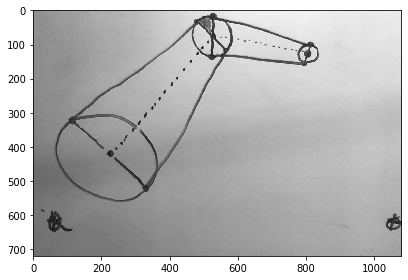

In [14]:
in_grayed = skimage.color.rgb2gray(in_image)
_ = skimage.io.imshow(in_grayed)

### Bonus
There may be value to custom color-to-grayscale mapping as explained in the article, [Photoshop Black and White Conversions – Hue/Saturation Adjustment](https://www.photoshopessentials.com/photo-editing/black-and-white-tutorials/hue-saturation/)

### A second opinion

OpenCV and its Python interface `cv2` come pre-installed on Colab. They have [`calcHist()`](https://docs.opencv.org/master/d1/db7/tutorial_py_histogram_begins.html).

Here's someone who has already gone through the OpenCV on Colab tire kicking:
[Computer Vision - Instructional Exercise](https://colab.research.google.com/drive/1RWGmqoEQdeyh5TssoGtsXsFk8hbLGtWp). The next few cells repro those notes in the context of whiteboard images.

Let's get a second opinion from OpenCV, using some code from [that CleverGirl article](https://www.pyimagesearch.com/2014/01/22/clever-girl-a-guide-to-utilizing-color-histograms-for-computer-vision-and-image-search-engines/). 

In [15]:
# convert the image to grayscale and create a histogram
cv2_img = cv2.imread(in_file_name)
cv2_grayed = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)

print(cv2_grayed[0,0])
# img_n = cv2.normalize(src=img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


144


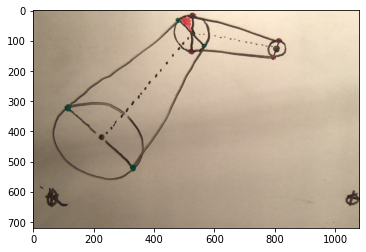

In [16]:
def show_cv2_img(a_cv2_img):
  """cv2's BGR => normal world RGB => MPL show()"""
  imgrgb = cv2.cvtColor(a_cv2_img, cv2.COLOR_BGR2RGB)
  #sns.set_style('dark')
  plt.imshow(imgrgb)
  plt.show()
show_cv2_img(cv2_img)

In [17]:
#Python: cv2.calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]]) → hist
intensities = cv2.calcHist([cv2_grayed], [0], None, [256], [0, 256])
print(intensities.shape)
print(intensities[101])

intensities_cumulative = intensities.cumsum()

(256, 1)
[249.]


### Color vs grayscale ravel()

The one on the left is technically ok but probably not what we want in the UI, rather the grayscale image raveled is more informative to the human eye

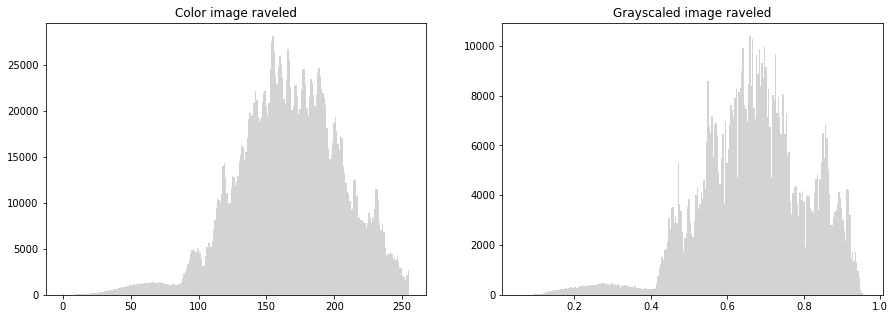

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

_ = ax1.hist(in_image.ravel(), bins = 256, color = 'lightgray', )
_ = ax1.set_title('Color image raveled')

_ = ax2.hist(in_grayed.ravel(), bins = 256, color='lightgray')
_ = ax2.set_title('Grayscaled image raveled')

From here on in, the visualization on the left will not be used.

## Intensity distribution plots

[TODO: Is there a name for this in the image processing world?]

In [0]:
eight_bit_range = np.arange(0, 256, 1)

### Hists by OpenCV

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


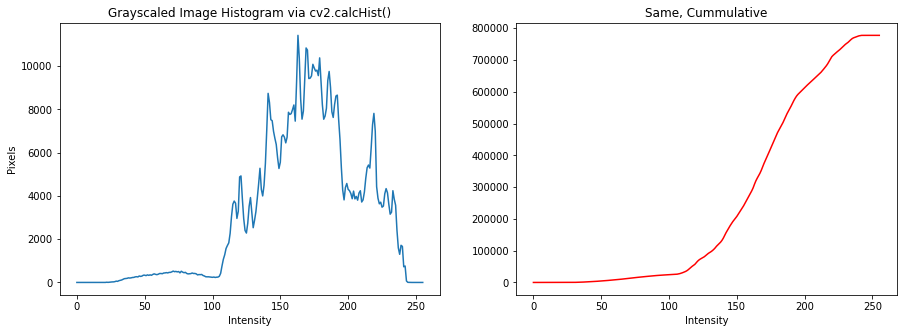

In [20]:
%time

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
_ = ax1.plot(intensities)
ax1.set_title("Grayscaled Image Histogram via cv2.calcHist()")
ax1.set_xlabel("Intensity")
ax1.set_ylabel("Pixels")

_ = ax2.plot(intensities_cumulative, color='r')
_ = ax2.set_title("Same, Cummulative")
_ = ax2.set_xlabel("Intensity")

### Hists by Matplotlib

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


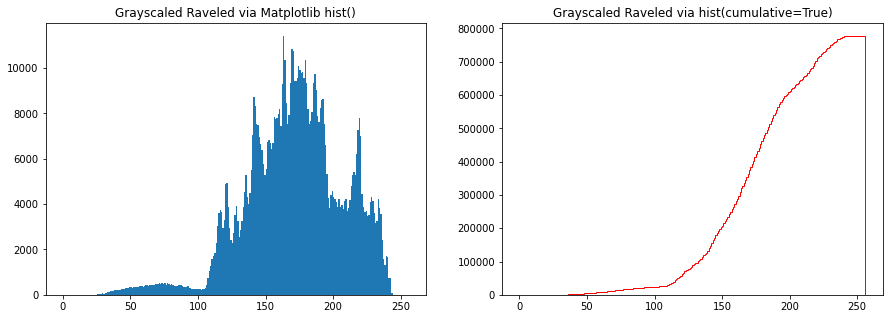

In [21]:
%time

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

_ = ax1.hist(cv2_grayed.ravel(),256,[0,256], histtype='bar')
_ = ax1.set_title("Grayscaled Raveled via Matplotlib hist()")

_ = ax2.hist(cv2_grayed.ravel(),256,[0,256], cumulative=True, histtype='step', color='r')
_ = ax2.set_title("Grayscaled Raveled via hist(cumulative=True)")

#### Effect of auto-binning 

In this next juxtaposition, the only difference is that one uses `bins='auto'`.

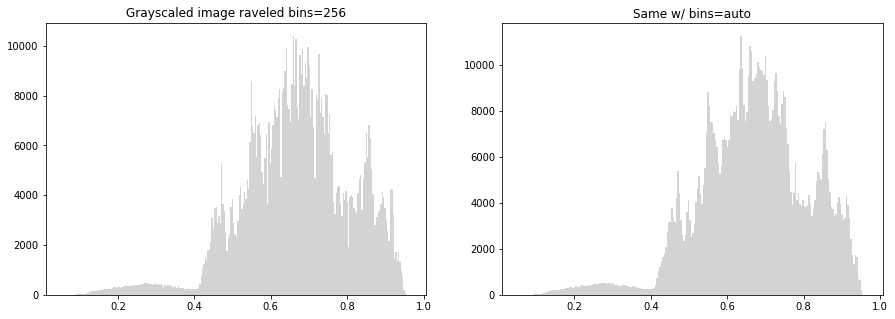

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

_ = ax1.hist(in_grayed.ravel(), bins = 256, color='lightgray')
_ = ax1.set_title('Grayscaled image raveled bins=256')

_ = ax2.hist(in_grayed.ravel(), bins='auto', color='lightgray')
_ = ax2.set_title('Same w/ bins=auto')

### Hists by skimage.exposure

Starting to think "don't bet against skimage." Just everything tweaked out correctly for the domain, and usually more preformant

skimage.exposure has [cumulative_distribution](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.cumulative_distribution) and [histogram](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.histogram). There may well be performance benefits for going this way:
>Unlike numpy.histogram, this function returns the centers of bins and does not rebin integer arrays. For integer arrays, each integer value has its own bin, which improves speed and intensity-resolution.

Nonetheless, `%time` here is showing `exposure` to be the slow one.

CPU times: user 68.7 ms, sys: 1.28 ms, total: 70 ms
Wall time: 67.5 ms


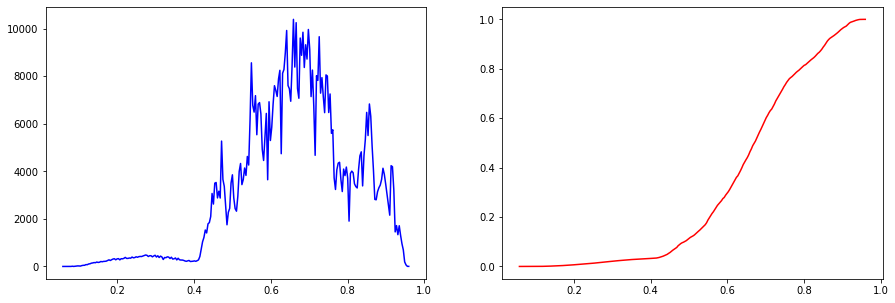

In [23]:
%%time

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))  

bins_cnt = 256 

intensities_histed, bins_out = skimage.exposure.histogram(in_grayed, bins_cnt)
_ = ax1.plot(bins_out, intensities_histed, 'b')

img_cdf, bins_out = skimage.exposure.cumulative_distribution(in_grayed, bins_cnt)
_ = ax2.plot(bins_out, img_cdf, 'r')

### Hists by Bokeh

The following `quad()` based rendering unfortuneately has horizontal gaps i.e. pixel-wide vertical white line artifacts.

In [24]:
max_bar_value = np.max(intensities) # pixels_hist_df.max(axis=0)['count'] 
p_jft = bokeh.plotting.figure(title='Dual Histogram', background_fill_color="#fafafa", x_range=(0,255), y_range=(0,max_bar_value*1.2))
p_jft.toolbar.logo = None

# Navy blue solid block of bars (hopefully)
hist, edges = np.histogram(in_grayed.ravel(), density=False, bins=256)
p_jft.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="navy", line_color="navy", alpha=1.0)

# Red line for cummulative total
total_pixels = intensities_cumulative[-1]
# How to get "twin axes": two plots sharing x, having different y ranges
#   https://docs.bokeh.org/en/latest/docs/user_guide/plotting.html#twin-axes
p_jft.extra_y_ranges = {"foo": Range1d(start=0, end=total_pixels*1.00)}
p_jft.step(eight_bit_range, intensities_cumulative, line_width=1, line_color='darkred', mode="after", y_range_name='foo')

bokeh.plotting.show(p_jft)

In [25]:
DataTable(pd.DataFrame(hist))

,0
0,1
1,1
2,2
3,1
4,3
...,...
251,697
252,192
253,65
254,5


In [26]:
# https://docs.bokeh.org/en/latest/docs/user_guide/plotting.html#bars


histies, _ = np.histogram(in_grayed.ravel(), bins=256)

p = bokeh.plotting.figure(plot_width=1000, plot_height=600)
p.vbar(x=eight_bit_range, width=0.90  , bottom=0,
#       top=pixels_hist_df['count'], color="navy")
       top=histies, color="navy")
p.toolbar.logo = None
bokeh.plotting.show(p)

TODO: WTF? why are there 0's in the hist? Is this the image? Notice how have two sources. So, how did one go wrong? 

One is np.histogram and the other is cv2.

And a third will be skimage.exposure.histogram (which will probably be most accurate, if also fastest, or not).

In [27]:
print(histies)

[    1     1     2     1     3     1     2    10     2     9    14    24
    20    17    38    48    50    78    75   105   113   139   148   164
   158   186   169   179   209   198   213   216   224   252   279   251
   285   313   325   281   319   330   278   327   321   342   381   339
   339   357   348   396   365   374   407   387   412   422   418   441
   466   482   470   419   452   452   405   442   471   397   450   377
   435   402   293   377   368   405   395   335   389   311   324   357
   276   346   281   270   271   257   232   217   236   253   209   216
   221   235   217   243   277   418   738  1039  1221  1533  1410  1791
  1846  2101  3070  2625  3505  3532  2883  3166  2878  5273  3661  3370
  2538  1753  2279  2445  3512  3855  2886  2434  2325  2959  3996  4331
  3442  3657  4141  3830  4627  4266  6139  8565  6775  6492  7184  5540
  6826  6893  6417  4928  4458  5488  6437  3647  6927  5298  5854  6826
  7603  7403  7150  7886  8250  4742  8126  8284  8

In [28]:
p = bokeh.plotting.figure(plot_width=1000, plot_height=600)
p.vbar(x=eight_bit_range, width=0.90  , bottom=0,
       top=intensities.ravel(), color="navy")
p.toolbar.logo = None
bokeh.plotting.show(p)

In [0]:
# TODO:Do the same but use skimage.exposure.histogram


In [0]:
#print(pixels_hist_df)
#print(source)
#print(source.column_names)

### Hist performance

Supposedly OpenCV is 40x faster than numpy?

https://docs.opencv.org/master/d1/db7/tutorial_py_histogram_begins.html

>OpenCV function is faster than (around 40X) than np.histogram(). So stick with OpenCV function.

### Juxtapose OpenCV and skimage
Finally, compare the two histograms and images, value for value, as generated by skimage and cv2. That would prove true equivalence.

## Histogram equalization



### EQ by `skimage.exposure`

[TODO: this tight 4 up is a nice display. Perhaps move this to matplotlib.ipynb.]

This next cell of code came from the skimage docs, [scikit-image: Histogram Equalization](https://scikit-image.org/docs/0.9.x/auto_examples/plot_equalize.html), which compares the effects of various histogram equalization techniques. Especially interesting looking is "adaptive histogram equalization" a.k.a. CLAHE.


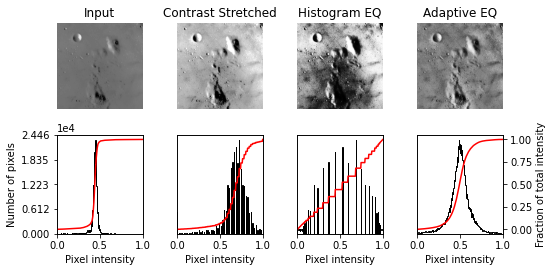

In [30]:
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = data.moon()

# Contrast stretching
p2 = np.percentile(img, 2)
p98 = np.percentile(img, 98)
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization (JFT: CLAHE!)
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
f, axes = plt.subplots(2, 4, figsize=(8, 4))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Input')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast Stretched')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram EQ')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive EQ')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
plt.subplots_adjust(wspace=0.4)
plt.show()


### Dual histogram

Here "dual histogram" is a plot of two histograms of a dataset, here a bucket full of pixel intensities:
- a normal binned distribution histogram
- a [cummulative histogram](https://en.wikipedia.org/wiki/Histogram#Cumulative_histogram)

By definition a cummulative histogram increases monotonical. In the above diagram the cummulative histogram is labeled "fraction of total intensity." skimage calls it cumulative distribution function (cdf).

This dual histogram can be used as a diagnostic tool. Flat parts of the red curve indicate wasted expressive potential. Notice how the two best looking images have smooth red curves without jags and flats (almost looks like aliasing).


Another way to get cummulative histogram is [[*](https://scikit-image.org/docs/0.9.x/auto_examples/plot_equalize.html)]:
```python
from skimage import exposure
img_cdf, bins = exposure.cumulative_distribution(img, 256)
```

In [31]:
print(eight_bit_range.shape)

print(intensities.shape)
print(intensities[:20])

p = bokeh.plotting.figure(plot_width=1000, plot_height=600)
#tops = intensities.reshape((256,)).astype(np.uint8)
tops = intensities.ravel().astype(np.uint8)
print(tops)

p.vbar(x=eight_bit_range, width=0.90  , bottom=0,
       top=tops, color="navy")
p.toolbar.logo = None
bokeh.plotting.show(p)

(256,)
(256, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [2.]
 [1.]
 [4.]]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   2
   1   4   2   1  10   4  11  18  24  26  37  60  50  81  97 113 141 174
 184 189 212 203 213 229 233   1  10 254  42  23  39  78  81  59  94  72
  94  76 115 141 118 104 124 157 157 148 179 184 198 184 209 209 233  13
 241 254 232 249 187   6 220 194 211 159 139 148 152 180 158 160 141  92
 109 104 113  66  43   8   3   5 252 248 237 249 231 243 247  27 164 250
  47 254  35 172  38 224 226  31 178  79 144 218  14  60  46 138  97 235
 181 189  84 167 226  57 200  43 196 157 209 159 138 128 140  36 127 100
  52  72   4 232 124 148 183  74 169  61  51  59 186  85 123  55  11  32
  63 157 102  19 123 240 118  86 243 209 227  76  99 185  42  86  88 140
 117  24 120  10 114 121  25  64 210 203  28 167 211 110 204 189 171 232
  36 222 210 145  15  29 126  22 136 219  35 143 134 232  87

In [32]:
print(intensities)
#print(list(intensities))

[[0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [1.0000e+00]
 [0.0000e+00]
 [2.0000e+00]
 [1.0000e+00]
 [4.0000e+00]
 [2.0000e+00]
 [1.0000e+00]
 [1.0000e+01]
 [4.0000e+00]
 [1.1000e+01]
 [1.8000e+01]
 [2.4000e+01]
 [2.6000e+01]
 [3.7000e+01]
 [6.0000e+01]
 [5.0000e+01]
 [8.1000e+01]
 [9.7000e+01]
 [1.1300e+02]
 [1.4100e+02]
 [1.7400e+02]
 [1.8400e+02]
 [1.8900e+02]
 [2.1200e+02]
 [2.0300e+02]
 [2.1300e+02]
 [2.2900e+02]
 [2.3300e+02]
 [2.5700e+02]
 [2.6600e+02]
 [2.5400e+02]
 [2.9800e+02]
 [2.7900e+02]
 [2.9500e+02]
 [3.3400e+02]
 [3.3700e+02]
 [3.1500e+02]
 [3.5000e+02]
 [3.2800e+02]
 [3.5000e+02]
 [3.3200e+02]
 [3.7100e+02]
 [3.9700e+02]
 [3.7400e+02]
 [3.6000e+02]
 [3.8000e+02]
 [4.1300e+02]
 [4.1300e+02]
 [4.0400e+02]
 [4.3500e+02]
 [4.4000e+02]
 [4.5400e+02]
 [4.4000e+02]
 [4.6500e+02]
 [4.6500e+02]
 [4.8900e+02]
 [5.25

## Contrast and brightness

>Brightness and contrast adjustments
Two commonly used point processes are multiplication and addition with a constant:
```
g(x)=αf(x)+β
```
The parameters α>0 and β are often called the gain and bias parameters; sometimes these parameters are said to control contrast and brightness respectively.
You can think of f(x) as the source image pixels and g(x) as the output image pixels. Then, more conveniently we can write the expression as:
```
g(i,j)=α⋅f(i,j)+β
```
where i and j indicates that the pixel is located in the i-th row and j-th column.



In [a OpenCV doc](https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html) it has a "Changing the contrast and brightness of an image" tutorial.


### Manual controls

Single RangeSliders

Analogous to what needs to be done to whiteboard images, [The Allen Institute calls the following "intensity windowing."](http://help.brain-map.org/display/mouseconnectivity/Projection#Projection-HighResolutionImageViewer) (in whiteboard context, mapping from uint8 to uint8, not uint16 to uint8).

We're doing similar but for manual histogram equalization (whatever that kind of windowing is called).

<img src="http://help.brain-map.org/download/attachments/2588674/fig1.jpg?version=1&modificationDate=1330647199754&api=v2" />


And the sides of the above Window box are controlled by a range UI.

<img src="http://help.brain-map.org/download/attachments/2588674/fig2.jpg?version=1&modificationDate=1330647299789&api=v2" width='60%'/>

**TODO:**
- [ ] Auto-run on change
  - Maybe 2 gForm sliders on autorun 
    - one alpha the other beta. 
  - Maybe 1 ipywidgets.IntRangeSlider  
- [ ] Draw the histogram with a&b ramp curve over histo.




So in Colab that might be [an IntRangeSlider](https://ipython-books.github.io/33-mastering-widgets-in-the-jupyter-notebook/) ipywidget?

In [33]:
range_slider = ipywidgets.IntRangeSlider(
    value=[100, 220],
    min=0, max=255, step=1,
    description='Red',
    readout_format='d',
)
range_slider

IntRangeSlider(value=(100, 220), description='Red', max=255)


OK, but also want to see how many pixels get mapped to 0 and 255, not just the range. How to count white pixels [[*](https://stackoverflow.com/a/47500956/4669056)]:
```python
np.sum(img == 255)
```


# White balance


- [Tutorials: White Balance](https://www.cambridgeincolour.com/tutorials/white-balance.htm) from a generic photographer perspective, good intro
- [Color Balance in Digital Imaging](https://www.microscopyu.com/digital-imaging/color-balance-in-digital-imaging) on microscopyu.com
- Some hand coding:
  - [Correcting image white balance with Python PIL and Numpy](https://codeandlife.com/2019/08/17/correcting-image-white-balance-with-python-pil-and-numpy/)
  - [Automatic White Balancing with Grayworld assumption
](https://stackoverflow.com/questions/46390779/automatic-white-balancing-with-grayworld-assumption)



[White Balance a photo from a known point](https://stackoverflow.com/a/54481969/4669056):
>The computation of lum will be better if using proper weights: 0.2126, 0.7152, 0.0722

## Simple White Balance

I think this might have started as this Matlab code [simplestColorBalance.m](https://web.stanford.edu/~sujason/ColorBalancing/simplestcb.html#nogo), as [discussed on stackoverflow](https://stackoverflow.com/a/49481583/4669056).

- https://stackoverflow.com/a/49481583/4669056
  - https://gist.github.com/DavidYKay/9dad6c4ab0d8d7dbf3dc

## Xphoto
https://stackoverflow.com/a/49836244/4669056:

>The answer can be found in [the xphoto documentation](https://docs.opencv.org/3.4.1/df/db9/namespacecv_1_1xphoto.html)
.  
>The appropriate methods to create the WB algorithms are createSimpleWB(), createLearningBasedWB() and createGrayworldWB().  
> &nbsp;   
>Example:
```python
wb = cv2.xphoto.createGrayworldWB()
wb.setSaturationThreshold(0.99)
image = wb.balanceWhite(image)
```


```
simple_wb = cv2.xphoto.createSimpleWB()
simple_img = simple_wb.balanceWhite(cv2_img)

gray_wb = cv2.xphoto.createGrayworldWB()
gray_wb.setSaturationThreshold(0.99)
gray_img = gray_wb.balanceWhite(cv2_img)

learning_wb = cv2.xphoto.createLearningBasedWB()
learning_img = learning_wb.balanceWhite(cv2_img)

show_cv2_img(cv2_img)
show_cv2_img(simple_img)
show_cv2_img(gray_img)
show_cv2_img(learning_img)

```

## Learning white balance

https://docs.opencv.org/master/dc/dcb/tutorial_xphoto_training_white_balance.html

>Many traditional white balance algorithms are statistics-based, i.e. they rely on the fact that certain assumptions should hold in properly white-balanced images like the well-known grey-world assumption. However, better results can often be achieved by leveraging large datasets of images with ground-truth illuminants in a learning-based framework. This tutorial demonstrates how to train a learning-based white balance algorithm and evaluate the quality of the results.

# Color 
[What about sns.pairplot. Scatter is not histo but it's still color analysis. So, this should be moved to "Color stats"?]

Separately it is describe in [Combo Charts with Seaborn and Python](https://towardsdatascience.com/combo-charts-with-seaborn-and-python-2bc911a08950)


## OpenCV vs skimage color

One is float 0..1, and other is uint8
```python
print(f'skimage: {in_grayed[0,0]}')
print(f'OpenCV: {cv2_grayed[0,0]}')
```

There seems to be a hassle on Colab WRT OpenCV. OpenCV used BGR color order, the reverse of the web's RGB order from HTML and CSS. But Colab doesn't like OpenCV's display utilities so we need to use something else, necessitating a translation from BGR => RGB.

Simply feeding a OpenCV image to Matplotlib will cause the colors to be interpreted as RGB, but they are really BGR. Notice how the pizza slice is blue in the following image (it should be red).

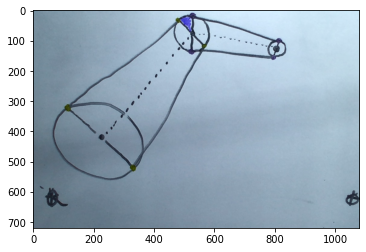

In [34]:
plt.rcParams["axes.grid"] = False
_ = plt.imshow(cv2_img) # ERROR: feeding BGR color; expects RGB color

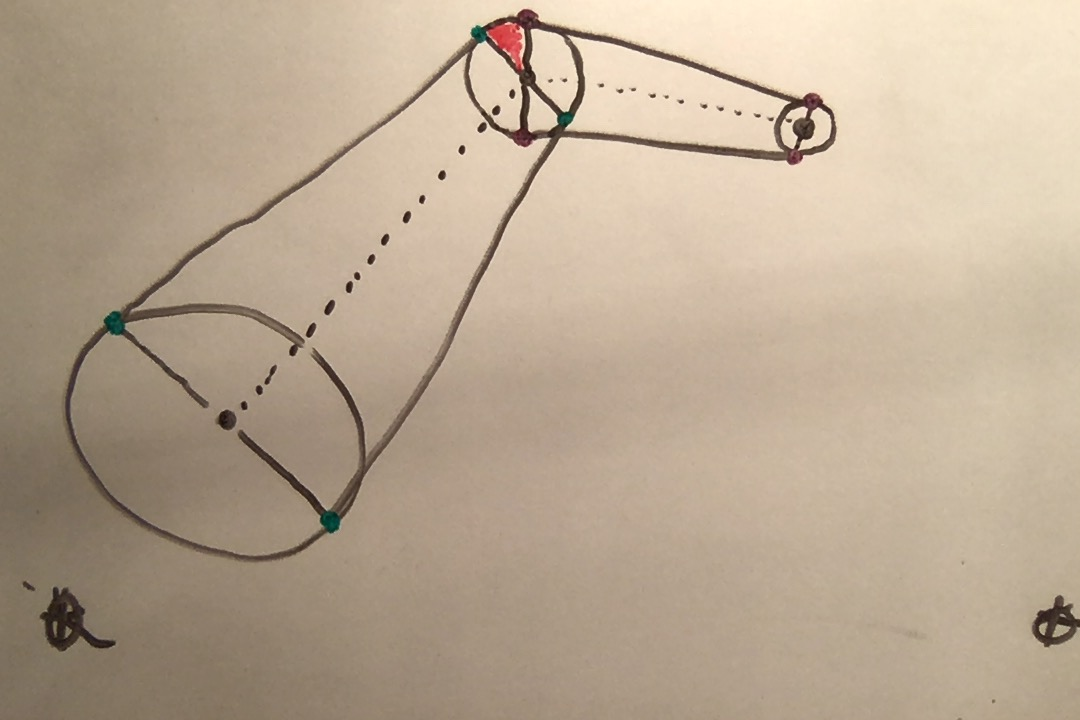

In [35]:
# TODO: temp patched on 2020-04-24
# Original code that Colab eventually disabled: 
#   cv2.imshow("gray", gray)
# See  https://github.com/reconstrue/brightfield/issues/206
# They suggested instead:
from google.colab.patches import cv2_imshow

cv2_imshow(cv2_img)


## Color histogram

Next is the per-channel histogram. Each of the 3 color channels is extracted in the only logical fashion: as the three channel slice 2D arrays. The fourth line (gray) is the one where there are two ways to proceed; choise depends on what you want to show. 

One way is to look at it as total: just `ravel()` all the values from the 3 channel slices into one shapeless bucket of unit8's and histogram the total. This technique is used in, for example, [Histograms in Image Processing with skimage-Python](https://towardsdatascience.com/histograms-in-image-processing-with-skimage-python-be5938962935):
```pyton
_ = plt.hist(image.ravel(), bins = 256, color = 'lightgray', ) # ravel() 3 colors together
_ = plt.hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
```


The other way is: show the perceived grayscale intensity. The latter is arguably more valuable for this whiteboarder project. In other words, the gray will maintain its meaning from the above plot of grayscale intensities.

Note this means that we should not attempt to convert some color image, `a_color_image` (x,y,3), to grayscale by simply calling `a_color_image.ravel()`. Calling `ravel()` will return an array of uint8 which is 3 times x times y. What we actually want is an array the same size as the number of pixels, not 3 times that full of numbers which do not correspond to human perceived luminance of the color image, rather simply the RGB colors broken apart to R, G, B.


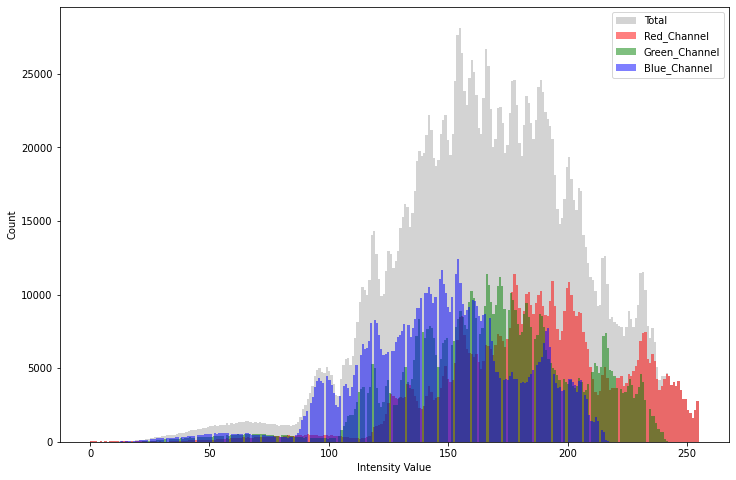

In [36]:
image = skimage.io.imread(in_file_name)

plt.figure(figsize=(12,8))
_ = plt.hist(image.ravel(), bins = 256, color = 'lightgray', ) # TODO: ravel() a color img? image = io.imread(in_file)
_ = plt.hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])

plt.rcParams["axes.grid"] = False
plt.rcParams["patch.linewidth"] = 0.001 # suppress plotting error noise
plt.show()

An visual cleaner version of roughly the same can be found in [OpenCV's demo hist](https://docs.opencv.org/master/d1/db7/tutorial_py_histogram_begins.html). Notice how intensities without any pixel are not as clearly represented.


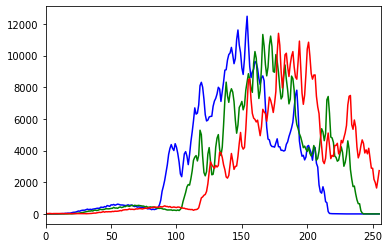

In [37]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([cv2_img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

## Triple RangerSliders
TODO: 3 sliders for 3 color channels. That's the controls to the 3 color range filter.

<img src="http://help.brain-map.org/download/attachments/2588674/ImageControl.PNG?version=1&modificationDate=1393875335570&api=v2" width="33%" />

## Exposure and brightness sliders?

[Tim Grey](http://asktimgrey.com/2016/07/11/exposure-versus-brightness/):
>the Exposure slider (such as that in Lightroom and Adobe Camera Raw) will use a scale based on exposure value (EV), which is measured in stops of light.
>
>A brightness adjustment also obviously adjusts the overall tonal values for an image, though with an adjustment typically measured as an overall percentage rather than exposure values.


## Color saturation 

[Saturation] is a feature of color.

Saturation is quite simple (via [[stackoverflow](https://stackoverflow.com/a/49280629/4669056)]):

>```
def change_brightness(img, alpha, beta):
   return cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype),0, beta)
```
Here alpha & beta are input parameters. Each pixel of the input image will change according to this formula.
```
  alpha(pixel_value) + beta.
```
Lower value of alpha like 2 or 3 is good


There is also more verbose options:
>The other answers suggest doing the saturation "by hand" using all kinds of numpy magic, but you can also use cv2.add() and let OpenCV handle that for you:
```python
import cv2
import numpy as np
image = cv2.read('image.png')
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
value = 42 #whatever value you want to add
cv2.add(hsv[:,:,2], value, hsv[:,:,2])
image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
cv2.imwrite('out.png', image)
```

Or less elegantly:
```python
img = cv2.imread('test.jpg') #load rgb image
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #convert it to hsv

h, s, v = cv2.split(hsv)
v += 255
final_hsv = cv2.merge((h, s, v))

img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
cv2.imwrite("image_processed.jpg", img)
```



## Pixels projected to color space



Consider this image from [Clever Girl: A Guide to Utilizing Color Histograms for Computer Vision and Image Search Engines](https://www.pyimagesearch.com/2014/01/22/clever-girl-a-guide-to-utilizing-color-histograms-for-computer-vision-and-image-search-engines/)

<img src="https://pyimagesearch.com/wp-content/uploads/2014/01/grant-2d-histograms.png" />

[Note how it calls a heatmap a 2D color histogram. herm.]

Those are 3 sides of a cube. The cube volume is color space. One could almost think of this as a 3D histogram, except that really stretched the definition of histogram. Each pixel from the 2D image is actually a 3-part chunk of info (R,G,B). So, use those values to project to 3D. Then the 2D projections of that 3D volume will be those "3 sides of a cube."

Finally, there are multiple cubes: one for each color coding:
- RGB
- HSV
- L*ab

OpenCV has easy functions for that: [cvtColor and friends](https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#cvtcolor).

# Microscopy techniques

Whiteboard images are kinda like brightfield microscopy images.



## CLAHE and Rolling ball

[skimage CLAHE](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_adapthist):
>`skimage.exposure.equalize_adapthist()`:
>Contrast Limited Adaptive Histogram Equalization (CLAHE).
>An algorithm for local contrast enhancement, that uses histograms computed over different tile regions of the image. Local details can therefore be enhanced even in regions that are darker or lighter than most of the image.

[brightfield issue](https://github.com/reconstrue/brightfield/issues/192):
- [23 - Histogram based image segmentation in Python](https://www.youtube.com/watch?v=kIVk0IhDMwY)
- [27 - CLAHE and Thresholding using opencv in Python](https://www.youtube.com/watch?v=XfDkg3z3BCg)
- [117 - Shading correction using rolling ball background subtraction](https://www.youtube.com/watch?v=hy5PlXX-CU0)
- [113 - Histogram equalization and CLAHE](https://www.youtube.com/watch?v=jWShMEhMZI4)


### Denoising

- https://github.com/reconstrue/brightfield/issues/203
- https://github.com/reconstrue/brightfield/issues/196

## Thresholding


Maybe first threshold to ink (any color) vs whiteboard. Then sort black, red, green.

[How to OTSU threshold in cv2](https://github.com/bnsreenu/python_for_microscopists/blob/master/027-image_processing_in_openCV_intro2-Thresholding.py):
```python
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("images/Alloy.jpg", 0)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  #Define tile size and clip limit. 
clahe_img = clahe.apply(img)

plt.hist(clahe_img.flat, bins =100, range=(0,255))

# binary thresholding
ret1,th1 = cv2.threshold(clahe_img,185,200,cv2.THRESH_BINARY)

# Otsu's thresholding, automatically finds the threshold point. 
#Compare wth above value provided by us (185)
ret2,th2 = cv2.threshold(clahe_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
```


#### Color thresholding

[Color Thresholding in OpenCV](https://medium.com/@ckyrkou/color-thresholding-in-opencv-91049607b06d) say define an upper and a lower bound color.

```python
lower_color_bounds = cv.Scalar(100, 0, 0)
upper_color_bounds = cv.Scalar(225,80,80)

gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
mask = cv2.inRange(frame,lower_color_bounds,upper_color_bounds )
mask_rgb = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
frame = frame & mask_rgb
cv2.imshow(‘Video’,frame)
```

# Dimensionality reduction

Neighborhooders (tSNE, UMAP, etc.) can easily project 3D color space to 2D, and then cluster pixels to classify to color.

5D = (x,y) (r,g,b) and a CNN would know neighborhood to detect line segments...

## K-Means
K-Means would have 4 cluster means a priori, one for each of the four colors.

## Black, white, red, green

My blackboard images are drawn with three dry erase pens:
- Black
- Red
- Green

The whiteboard is white, or transparent.


## K-Means color classification

If the goal is an image with only four colors, then this might well be a situation within which to apply [K-Means](https://www.youtube.com/watch?v=EItlUEPCIzM) classification.

So, in this case the answer classifies each pixel to one of four colors i.e. the number of classes is known a priori. Sounds like K-Means should be dusted off: [51 - Image Segmentation using K-means](https://www.youtube.com/watch?v=6CqRnx6Ic48).


## Color classifier pipeline

Maybe:
1. anything above a max is whited (and that's transparent). 
2. Anything below a min is black? 
3. then red and green should be seperable in the middle by histogram? OTSU? K-Means? SVM?




# Appendices

## Notes

Since Expos markers come in four packs, that fourth being blue. For public consumption, should probably extend my 3-pack personal theme to the four.

## ImageMagick

Note that file `whiteboard` which is a bash shell downloaded from [Fred](http://www.fmwconcepts.com/imagemagick/downloadcounter.php?scriptname=whiteboard&dirname=whiteboard). That is his unmodified code used here in this non-commercial notebook. It's cached to help this page init smoothly.


The immortal cockroach know as ImageMagick.

TODO:
- [x] `!cli -call_to` imagemagick
- [ ] Python to ImageMagick
  - [wand](http://docs.wand-py.org/en/0.5.9/)
  - PythonMagick


### Fred's Whiteboard

Years ago, Fred Weinhaus cranked out the tool which originally inspired this notebook to happen. His ImageMagick script, [Whiteboard](http://www.fmwconcepts.com/imagemagick/whiteboard/index.php), is described as "Processes a picture of a whiteboard to clean up the background and correct the perspective." Old but nonetheless it was "last modified: December 16, 2018" so it is also long maintained.

[2020-04-23: kicked Fred's whiteboard around a bit but results were unimpressive, although didn't get to quality of results shown in fmwconcepts.com. So, further exercising might get somewhere but this turned into an exercise in modern ML techniques before thoroughly exploring ImageMagick.]

In [0]:
# Peek inside that shell script file downloaded from Fred:

#freds_whiteboard_file_name = gdrive_data_root_path + 'whiteboard'
#!head -n 4 "{freds_whiteboard_file_name}"

#### Install Fred's

In [39]:
# TODO: this commented out next line fails. A file is created but not usable.
# !wget -O freds_whiteboard http://www.fmwconcepts.com/imagemagick/downloadcounter.php?scriptname=whiteboard&dirname=whiteboard
#
# Take #2 was to manual test: download from fmwconcepts.com, cache in private gDrive, download same to Colab FS works.
# That worked so that's why it's cached in gDrive as freds_whiteboard_file_name.

# So install is just a cp
freds_dest = workspace_root_path + 'whiteboard' # whiteboard is file's orig name
!cp "{freds_whiteboard_file_name}" {freds_dest}

cp: cannot stat '{freds_whiteboard_file_name}': No such file or directory


In [40]:
print(workspace_root_path)
!ls -lh {workspace_root_path} 

/content/whiteboarder/
total 4.0K
drwxr-xr-x 2 root root 4.0K Apr 30 21:32 cache


In [41]:
!chmod u+x {freds_dest}

chmod: cannot access '/content/whiteboarder/whiteboard': No such file or directory


#### Run Fred's

In [0]:
# !bash {freds_dest} -o 33 -e none -f 10 -S 150 -p 0.1 "{in_file_name}" out.jpg
#!bash {freds_dest} -S 300 "{in_file_name}" out.jpg

In [0]:
#out_img = PIL.Image.open("out.jpg")
#_ = plt.figure(figsize=(5,5))
#_ = plt.imshow(out_img)
#display(out_img)